# 准备工作
## \* Google Colab 部署使用

利用Google Colab可获取12GB RAM和8G GPU运算资源，减轻本地计算机负担。由于Colab是在服务器虚拟机上运行，不能和本地文件相连，因此需要将数据文件上传。而由于Colab的不稳定性，虚拟机在用户退出使用或遭到意外时会立即销毁，因此需要将文件上传到谷歌硬盘而非虚拟机。接下来的操作可以**让虚拟机在运行时连接到自己的谷歌硬盘**。

如果您是在本地计算机运行程序，请**不要运行**接下来的代码块。



In [ ]:
from google.colab import drive
drive.mount('/content/drive')  #连接到谷歌硬盘，会弹出一个链接，点击链接
                #并登录您的谷歌账号后，系统将提供一个密码，
                #复制到输入框内即可通过验证。

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Projects/TextMining/Text_Classifier1/DeepLearningTrain')
# 设定项目默认目录，默认My Drive下是谷歌硬盘根目录，根据实际情况配置。

# 接下来就可以使用相对地址了

Mounted at /content/drive


## 导入本次项目需要用到的包

In [ ]:
import sqlite3
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import sklearn
import string
import random
import matplotlib.pyplot as plt

# 数据读取与预处理

## 文本字符串清洗处理

In [ ]:
def split_spaces(data): ## 输入未处理的数据，第二列为文本，返回用空格分隔好第二列的字符串组成的列表。
    data_list = []
    for line in data:
        data_list.append(list(line))
        
    for item in data_list:
        item = ' '.join(list(item))
    return data_list

def desymbol(data):
    import re
    data_desymbol = []
    for line in data:
        data_desymbol.append(list(line))
    for row in data_desymbol:
        row[1] = re.sub(u"[^a-zA-Z0-9\u4E00-\u9FA5。]","",row[1]) #仅保留大小写字母、阿拉伯数字和汉字、句号。
    return data_desymbol

def add_start_end(data): #句子首尾添加标记，该处理仅在ngram策略下必须。
    data_with_se = []
    for line in data:
        data_with_se.append(list(line))
    for row in data_with_se:
        row[1] = "<start> "+row[1]+" <end>"
    return data_with_se


## 从sqlite3数据库文件读取数据

In [ ]:
def load_from_db(num,start):
    conn = sqlite3.connect("../data/database/texts.db")
    print ('Opened database successfully')
    c = conn.cursor()
    # 数据表结构(id,texts,type,sourceid)
    ci_data=[]
    cursor = c.execute("SELECT * from ci order by id desc limit "+str(start)+","+str(num))
    for row in cursor:
        ci_data.append(row)

    poet_data = []
    cursor=c.execute("SELECT * FROM poet order by id desc limit "+str(start)+","+str(num))
    for row in cursor:
        poet_data.append(row)

    classical_data = []
    cursor=c.execute("SELECT * FROM classical order by id desc limit "+str(start)+","+str(num))
    for row in cursor:
        classical_data.append(row)

    journal_data = []
    cursor=c.execute("SELECT * FROM journal order by id desc limit "+str(start)+","+str(num))
    for row in cursor:
        journal_data.append(row)
    
    news_data = []
    cursor=c.execute("SELECT * FROM news order by id asc limit "+str(start)+","+str(num))
    for row in cursor:
        news_data.append(row)

    print("所有类型数据读取成功，每类的条数："+str(num))
    conn.close()
    data = ci_data + poet_data + classical_data + journal_data + news_data
    
    # return add_start_end(desymbol(split_spaces(data)))
    return desymbol(data) # 初步清洗


In [ ]:
def get_text(data): # 将传入数据的文本内容单独提取出来成为列表
    textlist = []
    if(len(np.array(data).shape) > 1): # 如果传入的是多条数据而不是一条数据，np.array.shape返回的是一个二维tuple，长度大于1
        for row in data:
            textlist.append(row[0])
    else: textlist.append(data[1]) # 如果只传入一条数据，就只处理它的第二列
    return textlist

In [ ]:
train_data = load_from_db(18000,0)
test_data = load_from_db(2000,18000)

Opened database successfully
所有类型数据读取成功，每类的条数：18000
Opened database successfully
所有类型数据读取成功，每类的条数：2000


## 句子分割

使用神经网络进行深度学习时，要求输入的张量必须具有相同的维度，这对张量形状提出了要求。

根据我们先前对文本的总体把握，现代文文本语篇的平均长度要明显大于诗词等，如果本次实验还将语篇作为单个分类的对象，那么对于较短的语料其张量会存在着大量的空标签，造成影响很大的冗余，会大幅降低准确度，提升损失值，同时张量长度的增大也会造成计算的缓慢。因此我们需要转换策略，减少分类文本在字符长度上的悬殊。

我们决定使用句号`。`来切分文本，根据调研，调取各6000条语料，使用句号分割可以获得约25万条句子，而限定长度为40可以获得约23万条句子，较为合理，因此限定长度为40.

In [ ]:
def shorten_text(data):
  data_list = []
  for row in data:
    splited_sentence_list = row[1].split("。")
    for sentence in splited_sentence_list:
      if len(sentence) > 0 and len(sentence) < 40:
        data_list.append([sentence,row[2]])

  return data_list

In [ ]:
train_data_shortened = shorten_text(train_data)
test_data_shortened = shorten_text(test_data)
del train_data
del test_data


In [ ]:
# 废弃的代码：长度调研

# sentencelist = []
# max = 0
# count = 0

# for row in textlist:
#   splited = row.split("。")
#   for sentence in splited:
#     count += 1
#     if len(sentence) < 40 and len(sentence) > 0:
#       if len(sentence) > max: max = len(sentence)
#       sentencelist.append(sentence)

# print(max)
# print(count)
# print(len(sentencelist))


39
259543
190819
['净洗妒春颜色胜小红临水湔裙', '烟渡远应怜旧曲换叶移根', '山中去年人到怪月悄风轻闲掩重门', '琼肌瘦损那堪燕子黄昏', '几片故溪浮玉似夜归深雪前村', '芳梦冷双禽误宿粉云', '绀葩乍坼', '笑烂漫娇红不是春色', '换了素妆重把青螺轻拂', '旧歌共渡烟江却占玉奴标格']


In [ ]:
x_train = []
y_train = []
for row in train_data_shortened:
  x_train.append(row[0])
  y_train.append(row[1])
del train_data_shortened

x_dev = []
y_dev = []
for row in test_data_shortened:
  x_dev.append(row[0])
  y_dev.append(row[1])
del test_data_shortened

## X标签处理：转化为字向量

### 方法1：词袋法(TF-IDF)[请勿运行]

**结果较差，可以再调试**

利用自己的语料训练自己的向量转化模型。

> TF-IDF(term frequency-inverse document frequency)词频-逆向文件频率。该模型认为，字词的重要性与其在文本中出现的频率成正比(TF)，与其在语料库中出现的频率成反比(IDF)。
> 
> TF为某个词在文章中出现的总次数。为了消除不同文章大小之间的差异，便于不同文章之间的比较，我们在此标准化词频：$TF = \dfrac{某个词在文章中出现的总次数}{文章的总词数}。$
>
> IDF为逆文档频率。逆文档频率 $IDF = log \dfrac{词料库的文档总数}{包含该词的文档数+1} $。
>
> 为了避免分母为0，所以在分母上加1。
>
> $TF-IDF值 = TF * IDF。$
>
> 这里我们同时加入了ngram参数，必要时考虑前后词共现关系。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(analyzer='char', max_features=20000,ngram_range=(1,1)) #设置analyzer为char，构建字向量 
tv.fit(get_text(train_data_shortened))
print("TfidfVectorizer generated as tv！")

def tfIdf_Vectorize(x):
    x_vectorized = tv.transform(x)
    
    return x_vectorized

TfidfVectorizer generated as tv！


In [ ]:
x_train_vectorized = tfIdf_Vectorize(x_train)
x_dev_vectorized = tfIdf_Vectorize(x_dev)

## 方法2：词嵌入(Word2Vec)——引入预训练模型[请勿运行]

[word2vec模型链接](https://github.com/Embedding/Chinese-Word-Vectors)

下载的是Word + Character + Ngram

**还没有跑通**

In [ ]:
import gensim
myPath = '../data/merge_sgns_bigram_char300.txt' # 本地词向量的地址
Word2VecModel = gensim.models.KeyedVectors.load_word2vec_format(myPath) # 读取词向量，以二进制读取


KeyboardInterrupt: ignored

In [ ]:
# vector = Word2VecModel['噫']  # 词语的向量，是numpy格式
import numpy as np
print(Word2VecModel['意'])

[-4.224100e-01 -2.108890e-01  2.473650e-01  3.102880e-01 -3.031570e-01
  2.842700e-02 -5.482950e-01 -1.461430e-01 -1.103680e-01  8.799370e-01
 -1.886000e-03 -7.581060e-01  1.145700e-02 -5.664480e-01  2.624300e-01
 -3.254210e-01  2.212950e-01 -6.477000e-03 -8.977900e-02  1.072850e-01
  8.461000e-02 -1.986900e-01 -9.416000e-03  3.536080e-01  1.059860e-01
  5.836770e-01  1.918890e-01 -4.236980e-01  6.523030e-01 -4.109860e-01
  4.053230e-01  8.980600e-02  7.487850e-01 -9.430500e-02  7.226100e-02
 -1.303250e-01 -1.077870e-01  1.642570e-01 -5.088950e-01  5.539720e-01
  2.991170e-01 -3.877500e-02 -3.414900e-02  1.853330e-01  1.634130e-01
 -3.522000e-03 -1.224650e-01  5.990800e-02  2.384990e-01  2.837770e-01
  5.313740e-01  3.853610e-01 -1.732070e-01  1.492600e-01 -1.480240e-01
 -6.927660e-01  3.477000e-01  3.238000e-02  2.434780e-01 -1.011770e-01
 -2.283680e-01  1.221710e-01 -4.130310e-01  1.661670e-01 -5.640110e-01
  6.967200e-02 -6.567950e-01  4.519600e-01 -6.039500e-02  4.110020e-01
  1.27

In [ ]:
vocab_list = [char for char, Vocab in Word2VecModel.vocab.items()]
char_index = { "" : 0 }
char_vector = {}
embedding_matrix = np.zeros((len(vocab_list)+1,Word2VecModel.vector_size))

for i in range(len(vocab_list)):
  char = vocab_list[i]
  char_index[char] = i + 1
  char_vector[char] = Word2VecModel[char]
  embedding_matrix[i+1] = Word2VecModel[char]


NameError: ignored

In [ ]:
def char_tokenize(textlist,char_index):
  data = np.zeros((len(textlist),40))
  i = 0
  j = 0
  for sentence in textlist:
    for char in sentence:
      try:data[i][j] = char_index[char]
      except:data[i][j] = 0 # 字典找不到的情况填充0
      j += 1
    i += 1
    j = 0
  return data

In [ ]:
x_train_vectorized = char_tokenize(x_train,char_index)
x_dev_vectorized = char_tokenize(x_dev,char_index)

## 方法3： 不引入预训练模型，依赖现有语料构建字索引表

**结果较差，还有优化空间**

In [ ]:
vocablist = []
for sentence in x_train:
  for char in sentence:
    vocablist.append(char)
vocablist = list(set(vocablist))

# print(len(vocablist)) #18000 -10744

char2index = {'padding':0,'':1}
index2char = {0:'padding',1:''}
for index,char in enumerate(vocablist):
  char2index[char] = index
  index2char[index] = char

In [ ]:
def get_indices(list_x):
  x_train_indices = []
  for row in list_x:
    row_indices = []
    for char in row:
      try:row_indices.append(char2index[char])
      except:row_indices.append(1) # 字典中不存在该字
    for i in range(len(row_indices),40):
      row_indices.append(0)
    x_train_indices.append(row_indices)
  return x_train_indices

x_train_indices = get_indices(x_train)
x_dev_indices = get_indices(x_dev)

print(x_train[:1],x_train_indices[:1])
print(len(x_train_indices[0]))

['乍卷珠帘新燕入'] [[2888, 4353, 4482, 5744, 9190, 4293, 8846, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
40


## y标签处理

In [ ]:
def encode_y(y):
  y_o = []
  for label in y:
      if label =="modern":
        y_o.append(0)
      elif label =="ci":
        y_o.append(1)
      elif label =="poet":
        y_o.append(2)
      elif label =="classical":
        y_o.append(3)
  return y_o

y_train_encoded = encode_y(y_train)
y_dev_encoded = encode_y(y_dev)
# del y_train
# del y_dev

print(len(y_train_encoded))
print(len(x_train_indices))

570538
570538


In [ ]:
class Dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
print(len(x_train_indices))
print(len(y_train_encoded))
train_DL = DataLoader(Dataset(np.array(x_train_indices),np.array(y_train_encoded)),batch_size=512,shuffle=True) #需要转置为array，否则多维会出现转置问题
# train_DL = DataLoader(Dataset(x,y_train_encoded),batch_size=128,shuffle=True)
dev_DL = DataLoader(Dataset(np.array(x_dev_indices),np.array(y_dev_encoded)),batch_size=512,shuffle=True)

570538
570538


# 网络搭建

在外部将词index序列进行embedding后传入网络

## 网络结构

* Embedding

* GRU

* Linear



In [91]:

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

class CharRNN(nn.Module):
    def __init__(self,input_size, embed_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(input_size,embed_size,padding_idx=0)
        self.gru = nn.GRU(embed_size, hidden_size, 1, batch_first=True)
        self.liner = nn.Linear(hidden_size, output_size)

    def train(self,train_DL):
        train_loss = 0
        train_accuracy = 0
        for i,(x,y) in enumerate(train_DL):
          x = x.to(device)
          y = y.to(device)
          output = model(x)
          loss = criterion(output,y)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
          train_accuracy += (output.argmax(1) == y).sum().item()
        scheduler.step()

        return train_loss / len(x_train_indices) , train_accuracy / len(x_train_indices)

    def test(self,test_DL):
        loss = 0
        acc = 0
        for i,(x,y) in enumerate(test_DL):
          x = x.to(device)
          y = y.to(device)
          with torch.no_grad():
            output = model(x)
            loss = criterion(output,y)
            loss += loss.item()
            acc += (output.argmax(1) == y).sum().item()    
        return loss / len(x_dev_indices), acc / len(x_dev_indices)

    def forward(self, input):
        embedded = self.embedding(input)
        h0 = torch.zeros(1, len(embedded), self.hidden_size, device=device) # 初始hidden state
        output, hidden = self.gru(embedded, h0)
        output = output[:, -1, :] # 只使用最终时刻的输出作为特征
        output = self.liner(output)
        output = F.softmax(output, dim=1)
        return output



In [94]:
# %%time
model = CharRNN(input_size=len(vocablist),embed_size=300,hidden_size=128,output_size=4)
model = model.to(device)
history_epoches = []
history_loss = []
history_accu = []
test_loss = []
test_accu = []
EPOCHES = 10
criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
for i in range(EPOCHES):
  loss, accuracy = model.train(train_DL)
  history_epoches.append(str(i+1))
  history_loss.append(loss)
  history_accu.append(accuracy)
  print("Epoch{}/{}.\nResult:\n[Train]loss:{},accuracy:{}".format(i+1,EPOCHES,loss,accuracy))
  dev_loss,dev_accu = model.test(dev_DL)
  test_loss.append(dev_loss)
  test_accu.append(dev_accu)
  print("[Test]  LOSS:{},ACCURACY:{}\n".format(dev_loss,dev_accu))


Epoch1/10.
Result:
[Train]loss:0.002255231459531273,accuracy:0.5854929908262027
[Test]  LOSS:3.0014138246770017e-05,ACCURACY:0.5807401123407756

Epoch2/10.
Result:
[Train]loss:0.002598811421116322,accuracy:0.41078946538179756
[Test]  LOSS:3.0860432161716744e-05,ACCURACY:0.5036054448000618

Epoch3/10.
Result:
[Train]loss:0.0026503935860526266,accuracy:0.38617059687523003
[Test]  LOSS:3.179371924488805e-05,ACCURACY:0.48928649468502167

Epoch4/10.
Result:
[Train]loss:0.0026631568991412335,accuracy:0.38044266990104075
[Test]  LOSS:3.202371226507239e-05,ACCURACY:0.4957518734173961

Epoch5/10.
Result:
[Train]loss:0.0026624497973612897,accuracy:0.38077568891116803
[Test]  LOSS:3.1439110898645595e-05,ACCURACY:0.4956361906965385

Epoch6/10.
Result:
[Train]loss:0.0026686313275848038,accuracy:0.3775366408547722
[Test]  LOSS:3.147372626699507e-05,ACCURACY:0.5056106119615933

Epoch7/10.
Result:
[Train]loss:0.0026672411832659713,accuracy:0.37870921831674664
[Test]  LOSS:3.0836403311695904e-05,ACCURA

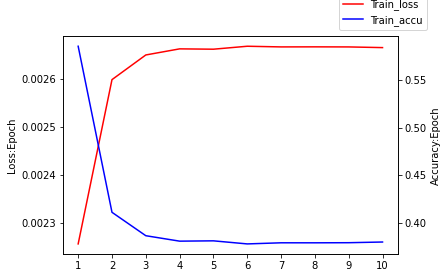

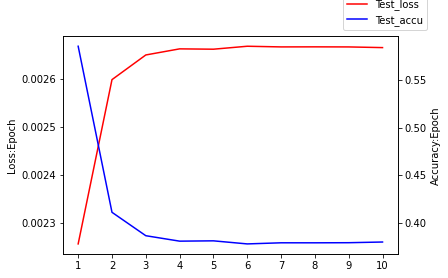

In [96]:
%matplotlib inline

def plot_history(epoch,loss,accuracy,title):
  x = epoch
  y1 = loss
  y2 = accuracy
  fig,ax1 = plt.subplots()
  ax1.plot(x,y1,'r',label=title+'_loss')
  ax1.set_ylabel('Loss:Epoch')
  ax2 = ax1.twinx()
  ax2.plot(x,y2,'b',label=title+'_accu')
  ax2.set_ylabel('Accuracy:Epoch')
  ax2.set_xlabel('Epoches')
  fig.legend(loc="upper right", bbox_to_anchor=(1, 1))
  plt.show()
plot_history(history_epoches,history_loss,history_accu,title='Train')
plot_history(history_epoches,history_loss,history_accu,title='Test')

> **训练集、测试集loss容易出现的问题总结**
>
>* train loss不断下降，test loss不断下降:说明网络仍在学习;
>* train loss 不断下降，test loss趋于不变:说明网络过拟合;
>* train loss趋于不变，test loss不断下降:说明数据集100%有问题;
>* train loss趋于不变,test loss趋于不变:说明学习遇到瓶颈，需要减小学习率或批量数目;或者是数据集有问题(数据集标注错误数据比较多)
>* train loss 不断上升，test loss不断上升:说明网络结构设计不当，训练超参数设置不当，数据集经过清洗等问题。
